**Note:** This notebook is partially based on a notebook authored by Chris Tralie, which can be found at: https://github.com/ctralie/TDALabs/blob/master/3DShapes.ipynb

In [1]:
# install persim
! pip install persim

     |████████████████████████████████| 47 kB 2.8 MB/s 
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18119 sha256=482a6179566a240281540da0459cc9e3cb64b17fd9bfdd34c872bde3904bde49
  Stored in directory: /root/.cache/pip/wheels/d2/9f/a8/67f1b86e47cd17338d3d07939f4660378e65b758c4594f96e3
Successfully built hopcroftkarp


In [3]:
# necessary imports
import numpy as np
import matplotlib.pyplot as plt
from persim import plot_diagrams
from persim import PersistenceImager
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import pickle
from urllib.request import urlopen
from io import BytesIO

In [4]:
# download data to variables
url = "https://github.com/LuisScoccola/emalca-applied-topology-minicourse/blob/main/data/poseClassificationPickle?raw=true"
f = urlopen(url)
meshes, dgmsSub0, dgmsSub1 = pickle.load(f)

In [5]:
# define functions to plot
def plotPCfn(VPos, fn, cmap = 'afmhot'):
    """
    plot an XY slice of a mesh with the scalar function used in a 
    sublevelset filtration
    """
    x = fn - np.min(fn)
    x = x/np.max(x)
    c = plt.get_cmap(cmap)
    C = c(np.array(np.round(x*255.0), dtype=np.int64))
    plt.scatter(VPos[:, 0], VPos[:, 1], 10, c=C)
    plt.axis('equal')
    ax = plt.gca()
    ax.set_facecolor((0.3, 0.3, 0.3))

def plotPoseAndPD(subjectNum, poseNum):
  i = subjectNum + poseNum * 10
  fn = lambda VPos, ITris: VPos[:, 1]
  (VPos, ITris) = meshes[i]
  x = fn(VPos, ITris)
  plt.figure(figsize=(10, 2))
  plt.subplot(131)
  plotPCfn(VPos, x, cmap = 'afmhot')
  plt.title("Subject %i Pose %i"%(subjectNum, poseNum))
  plt.subplot(132)
  plotPCfn(VPos[:, [2, 1, 0]], x, cmap = 'afmhot')
  plt.subplot(133)
  plot_diagrams([dgmsSub0[i],dgmsSub1[i]])
  plt.show()

def plotProjection(proj):
  plt.figure(figsize=(4,4))
  plt.scatter(proj[:,0], proj[:,1], c=(np.arange(0,len(proj)) // 10) )
  for i,txt in enumerate(np.arange(0,len(proj)) // 10):
      plt.annotate(txt, proj[i])
  plt.show()

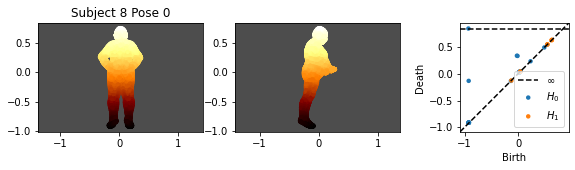

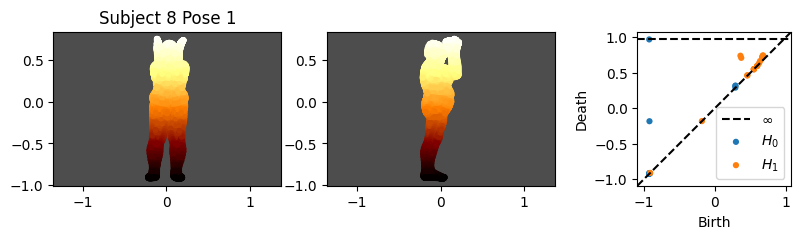

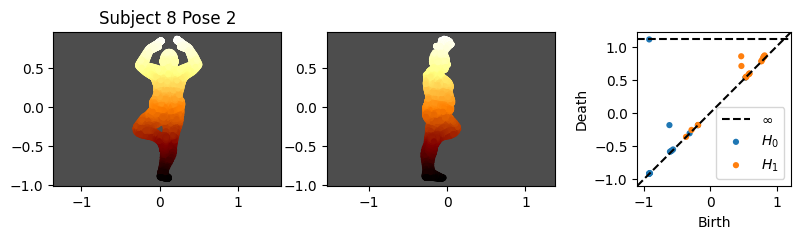

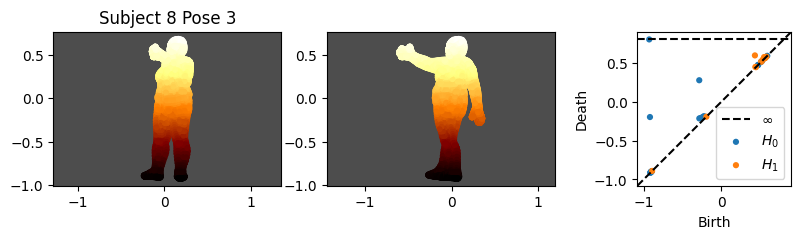

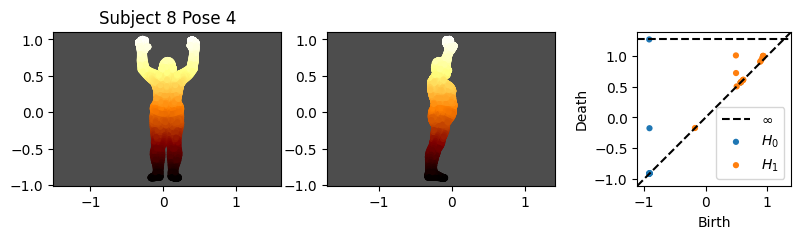

In [6]:
subjectNum = 8 # must be between 0 and 9 included

for poseNum in range(5):
  plotPoseAndPD(subjectNum, poseNum)

In [10]:
# find a useful value for ALPHA
ALPHA = 0.0001

dgmsSub0_ = [ dgm[np.isfinite(dgm[:,1]),:] for dgm in dgmsSub0 ]
pimgrSub0 = PersistenceImager(pixel_size=0.01, kernel_params={'sigma': ALPHA * np.array([[1.0, 0.0], [0.0, 1.0]])})
pimgrSub0.fit(dgmsSub0_)
imgsSub0 = pimgrSub0.transform(dgmsSub0_)
imgsSub0_array = np.array([img.flatten() for img in imgsSub0])

imgs_array = imgsSub0_array

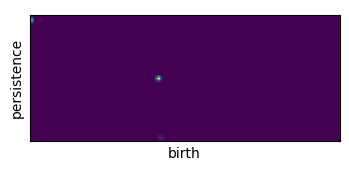

In [11]:
plt.figure(figsize=(4,2))
pimgrSub0.plot_image(imgsSub0[0])
plt.show()

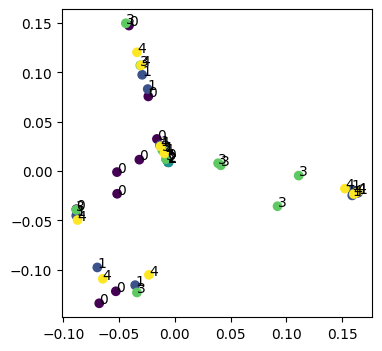

In [12]:
pca = PCA(n_components=2)
proj = pca.fit_transform(imgs_array)

plotProjection(proj)

In [13]:
pimgrSub1 = PersistenceImager(pixel_size=0.01, kernel_params={'sigma': ALPHA * np.array([[1.0, 0.0], [0.0, 1.0]])})
dgmsSub1_ = [ dgm[np.isfinite(dgm[:,1]),:] for dgm in dgmsSub1 ]

pimgrSub1.fit(dgmsSub1_)
imgsSub1 = pimgrSub1.transform(dgmsSub1_)
imgsSub1_array = np.array([img.flatten() for img in imgsSub1])

imgs_array = np.column_stack((imgsSub0_array,imgsSub1_array))

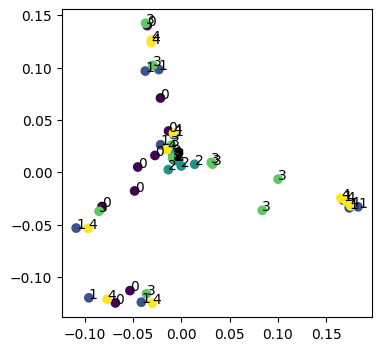

In [14]:
pca = PCA(n_components=2)
proj = pca.fit_transform(imgs_array)

plotProjection(proj)

#**Optional:** A more involved machine learning task.

The goal is to do classification of a dataset of molecules used in, e.g., (Polanco, Perea, 2020), found at: https://ieeexplore.ieee.org/document/8999105

The dataset consists of 1357 molecules. In the next cell, we import the data and a specific classification problem.

In [34]:
url = "https://github.com/lucho8908/adaptive_template_systems/blob/master/Examples/Proteins/diagrams.pickle?raw=true"
f = urlopen(url)
diagrams = np.array(pickle.load(f))

In [71]:
learning_task = 40 # There are 55 learning tasks, choose number between 1 and 55

# download the train and test indices, and train and test labels
test_indices_url = "https://github.com/lucho8908/adaptive_template_systems/blob/master/Examples/Proteins/Index/TestIndex" + str(learning_task) + ".npy?raw=true"
train_indices_url = "https://github.com/lucho8908/adaptive_template_systems/blob/master/Examples/Proteins/Index/TrainIndex" + str(learning_task) + ".npy?raw=true"
test_labels_url = "https://github.com/lucho8908/adaptive_template_systems/blob/master/Examples/Proteins/Index/TestLabel" + str(learning_task) + ".npy?raw=true"
train_labels_url = "https://github.com/lucho8908/adaptive_template_systems/blob/master/Examples/Proteins/Index/TrainLabel" + str(learning_task) + ".npy?raw=true"

test_indices = np.load(BytesIO(urlopen(test_indices_url).read()))
train_indices = np.load(BytesIO(urlopen(train_indices_url).read()))
test_labels = np.load(BytesIO(urlopen(test_labels_url).read()))
train_labels = np.load(BytesIO(urlopen(train_labels_url).read()))

train_data = diagrams[train_indices]
test_data = diagrams[test_indices]

In [72]:
# each training datum contains the name of a molecule, its H0 persistence diagram and its H1 persistence diagram

print(train_data[0].keys())

dict_keys(['name', 'h0', 'h1'])


Each classification problem has two classes: -1 and 1

**Goal:** Train your favourite binary classification tool using as input the persistence images of the persistence diagrams of the molecules.

**Note:** There are 55 classifications tasks. Some of them are very easy. Try your method on many (or all) tasks.